# Quantile Regression with ε-tolerance

[![Slides](https://img.shields.io/badge/🦌-ReHLine-blueviolet)](https://rehline-python.readthedocs.io/en/latest/)

Quantile Regression with ε-tolerance solves the following optimization problem:
$$
\min_{\mathbf{\beta} \in \mathbb{R}^d} \sum_{i=1}^{n} (\rho_\kappa(y_i - \mathbf{x}_i^\intercal \mathbf{\beta}) - \epsilon)_+ + \frac{\lambda}{2} \|\mathbf{\beta}\|^2
$$
where

*   $\rho_\kappa(r) = r \cdot (\kappa - \mathbf{1}(r < 0))$ is the check loss (quantile loss),
*   $\mathbf{x}_i \in \mathbb{R}^d$ is a feature vector,
*   $y_i \in \mathbb{R}$ is a continuous response variable,
*   $\kappa \in (0, 1)$ is the quantile level,
*   $\epsilon \geq 0$ is the tolerance parameter.


In [2]:
# Simulate Data
import numpy as np

np.random.seed(42)
n = 2000
x = np.random.randn(n)
noise = np.random.randn(n) * (0.3 + 0.5 * np.abs(x))
y = 2 * x + noise
X = np.column_stack([x, np.ones(n)])  # [x, 1] for intercept

In [3]:
from rehline import plqERM_Ridge

# Check Loss with epsilon-tolerance
clf = plqERM_Ridge(loss={'name': 'check_eps', 'qt': 0.9, 'epsilon': 0.1}, C=10.0/n)
clf.fit(X=X, y=y)

,loss,"{'epsilon': 0.1, 'name': 'check_eps', 'qt': 0.9}"
,constraint,[]
,C,0.005
,max_iter,1000
,tol,0.0001
,shrink,1
,warm_start,0
,verbose,0
,trace_freq,100


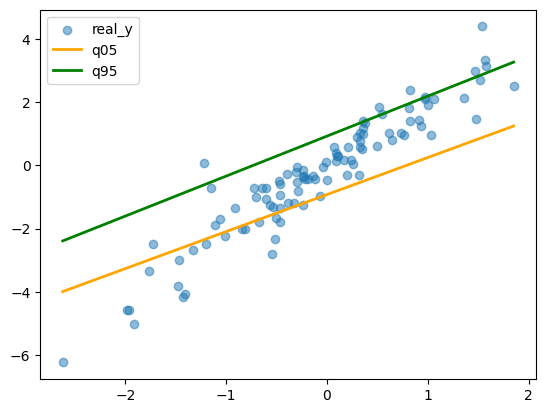

In [4]:
## plot Check Loss with epsilon results 
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from rehline import plqERM_Ridge

warnings.filterwarnings("ignore", "is_categorical_dtype")

# Parameters
epsilon = 0.3

# Fit Check Loss with epsilon (two quantiles)
clf05 = plqERM_Ridge(loss={'name': 'check_eps', 'qt': 0.05, 'epsilon': epsilon}, C=10.0/n)
clf05.fit(X=X, y=y)

clf95 = plqERM_Ridge(loss={'name': 'check_eps', 'qt': 0.95, 'epsilon': epsilon}, C=10.0/n)
clf95.fit(X=X, y=y)

# Plot
n_sample = 100
X_sample, y_sample = X[:n_sample], y[:n_sample]
q05_sample = clf05.decision_function(X_sample)
q95_sample = clf95.decision_function(X_sample)

# sort by x0
sort_idx = np.argsort(X_sample[:,0])
x0_sorted = X_sample[sort_idx, 0]
y_sorted = y_sample[sort_idx]
q05_sorted = q05_sample[sort_idx]
q95_sorted = q95_sample[sort_idx]

plt.scatter(x0_sorted, y_sorted, alpha=0.5, label='real_y')
plt.plot(x0_sorted, q05_sorted, 'orange', linewidth=2, label='q05')
plt.plot(x0_sorted, q95_sorted, 'green', linewidth=2, label='q95')
plt.legend()
plt.show()

Epsilon creates a tolerance zone where small residuals incur zero loss, so the model only penalizes deviations exceeding this threshold.

This produces tighter quantile intervals and more robust estimates, suitable for scenarios where small errors are acceptable but large deviations matter.

In [5]:
## Comparison: Original QR vs Check Loss with epsilon
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from rehline import plqERM_Ridge

warnings.filterwarnings("ignore", "is_categorical_dtype")

# Parameters
epsilon = 0.2

# Fit original QR
clf_qr05 = plqERM_Ridge(loss={'name': 'QR', 'qt': 0.05}, C=10.0/n)
clf_qr05.fit(X=X, y=y)

clf_qr95 = plqERM_Ridge(loss={'name': 'QR', 'qt': 0.95}, C=10.0/n)
clf_qr95.fit(X=X, y=y)

# Fit Check Loss with epsilon
clf_eps05 = plqERM_Ridge(loss={'name': 'check_eps', 'qt': 0.05, 'epsilon': epsilon}, C=10.0/n)
clf_eps05.fit(X=X, y=y)

clf_eps95 = plqERM_Ridge(loss={'name': 'check_eps', 'qt': 0.95, 'epsilon': epsilon}, C=10.0/n)
clf_eps95.fit(X=X, y=y)

,loss,"{'epsilon': 0.2, 'name': 'check_eps', 'qt': 0.95}"
,constraint,[]
,C,0.005
,max_iter,1000
,tol,0.0001
,shrink,1
,warm_start,0
,verbose,0
,trace_freq,100


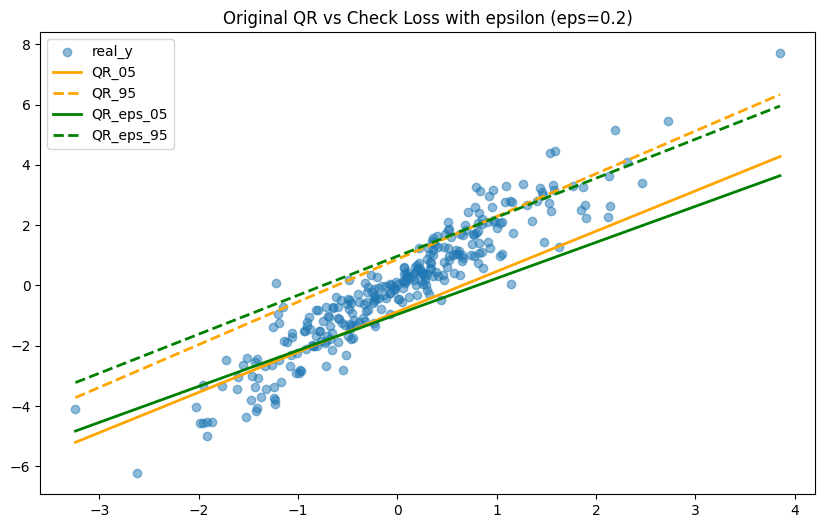

In [6]:
# Plot
n_sample = 300
X_sample, y_sample = X[:n_sample], y[:n_sample]

sort_idx = np.argsort(X_sample[:,0])
x0_sorted = X_sample[sort_idx, 0]
y_sorted = y_sample[sort_idx]

qr05_sorted = clf_qr05.decision_function(X_sample)[sort_idx]
qr95_sorted = clf_qr95.decision_function(X_sample)[sort_idx]
eps05_sorted = clf_eps05.decision_function(X_sample)[sort_idx]
eps95_sorted = clf_eps95.decision_function(X_sample)[sort_idx]

plt.figure(figsize=(10, 6))
plt.scatter(x0_sorted, y_sorted, alpha=0.5, label='real_y')
plt.plot(x0_sorted, qr05_sorted, 'orange', linewidth=2, label='QR_05')
plt.plot(x0_sorted, qr95_sorted, 'orange', linewidth=2, linestyle='--', label='QR_95')
plt.plot(x0_sorted, eps05_sorted, 'green', linewidth=2, label='QR_eps_05')
plt.plot(x0_sorted, eps95_sorted, 'green', linewidth=2, linestyle='--', label='QR_eps_95')
plt.legend()
plt.title(f'Original QR vs Check Loss with epsilon (eps={epsilon})')
plt.show()